In [2]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [16]:
import csv
import cv2
import mediapipe as mp  
import math
import os

# Initialize Mediapipe Pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Input folder containing video files
input_folder = 'A:\gym_tracker-ai\gym_tracker-ai\Diagonal Left and Right Squats Hands Front Raised Test #1'
output_csv = 'Diagonal Left and Right Squats Hands Front Raised.csv'

# Open the CSV file to write the angles
with open(output_csv, mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    # Write header row
    header = [f'Angle_{i}' for i in [11, 12, 13, 14, 23, 24, 25, 26]]
    csv_writer.writerow(header)

    # Process each video in the folder
    for video_file in os.listdir(input_folder):
        video_path = os.path.join(input_folder, video_file)
        if not video_file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            continue

        print(f"Processing video: {video_file}")

        # Open the video file
        cap = cv2.VideoCapture(video_path)

        with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Recolor image to RGB
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                # Make detection
                results = pose.process(image)

                # Recolor back to BGR
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                # Extract landmarks and calculate angles
                try:
                    if results.pose_landmarks:
                        landmarks = results.pose_landmarks.landmark
                        angles = []

                        # Extract required points for angle calculation
                        def get_coords(idx):
                            return [landmarks[idx].x, landmarks[idx].y]

                        # Define angle mapping
                        angle_map = {
                            11: (23, 11, 13),
                            12: (24, 12, 14),
                            13: (11, 13, 15),
                            14: (12, 14, 16),
                            23: (25, 23, 24),
                            24: (26, 24, 23),
                            25: (27, 25, 23),
                            26: (28, 26, 24)
                        }

                        for i, (a, b, c) in angle_map.items():
                            angle = calculate_angle(get_coords(a), get_coords(b), get_coords(c))
                            angles.append(angle)

                        # Write angles to CSV
                        csv_writer.writerow([video_file] + angles)

                except Exception as e:
                    print(f"Error processing frame: {e}")

                # Render detections
                mp_drawing.draw_landmarks(
                    image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
                )

                # Show the frame (optional, can be commented out for faster processing)
                cv2.imshow('Mediapipe Feed', image)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

        cap.release()

    cv2.destroyAllWindows()

print(f"Pose angles saved to {output_csv}")


Processing video: Nested Sequence 01.mp4
Processing video: Nested Sequence 02.mp4
Processing video: Nested Sequence 03.mp4
Processing video: Nested Sequence 04.mp4
Processing video: Nested Sequence 05.mp4
Processing video: Nested Sequence 07.mp4
Processing video: Nested Sequence 08.mp4
Processing video: Nested Sequence 09.mp4
Processing video: Nested Sequence 10.mp4
Processing video: Nested Sequence 11.mp4
Processing video: Nested Sequence 12.mp4
Processing video: Nested Sequence 13.mp4
Processing video: Nested Sequence 14.mp4
Processing video: Nested Sequence 15.mp4
Processing video: Nested Sequence 16.mp4
Processing video: Nested Sequence 17.mp4
Processing video: Nested Sequence 18.mp4
Processing video: Nested Sequence 19.mp4
Pose angles saved to Diagonal Left and Right Squats Hands Front Raised.csv


<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

Accuracy: 1.00
AUC: 1.00
Confusion Matrix:
[[560   0   3   0   0   0]
 [  0 554   1   0   0   0]
 [  3   2 436   0   0   0]
 [  0   0   0 473   0   0]
 [  0   0   0   0 579   0]
 [  0   0   0   0   0 229]]
Feature Importances:
    Feature  Importance
1  Angle_12    0.186770
0  Angle_11    0.171804
2  Angle_13    0.158513
3  Angle_14    0.134855
5  Angle_24    0.130736
6  Angle_25    0.081522
7  Angle_26    0.071145
4  Angle_23    0.064656


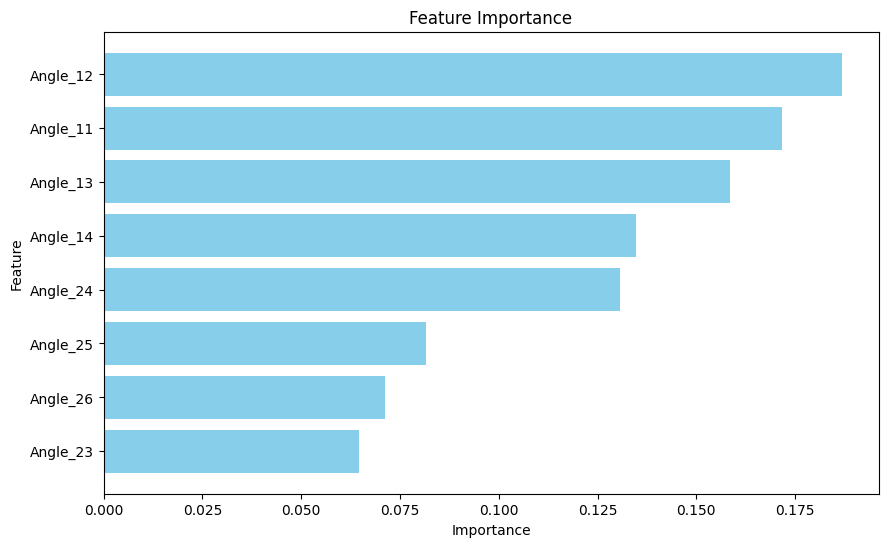

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('A:\gym_tracker-ai\gym_tracker-ai\Diagonal_Data.csv')

# Separate features and target
X = data.drop(['Class'], axis=1)  # Features
y = data['Class']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)  # Probabilities for AUC computation

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Compute AUC
try:
    if len(y.unique()) > 2:  # Multiclass case
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # 'ovo' also an option
    else:  # Binary case
        auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
    print(f'AUC: {auc_score:.2f}')
except ValueError as e:
    print(f"Error computing AUC: {e}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

# Get feature importance
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importance visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importances:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

In [25]:
import cv2
import mediapipe as mp
import math

# Load the trained Random Forest model
rf_model = model

# Initialize Mediapipe Pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Input video file or webcam (use 0 for webcam)
video_source = 1  # Change to a file path for processing a video
cap = cv2.VideoCapture(video_source)

# Angle mapping for calculation
angle_map = {
    11: (23, 11, 13),
    12: (24, 12, 14),
    13: (11, 13, 15),
    14: (12, 14, 16),
    23: (25, 23, 24),
    24: (26, 24, 23),
    25: (27, 25, 23),
    26: (28, 26, 24)
}

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks and calculate angles
        try:
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                angles = []

                # Extract required points for angle calculation
                def get_coords(idx):
                    return [landmarks[idx].x, landmarks[idx].y]

                # Calculate angles
                for i, (a, b, c) in angle_map.items():
                    angle = calculate_angle(get_coords(a), get_coords(b), get_coords(c))
                    angles.append(angle)

                # Predict class using the model
                predicted_class = rf_model.predict([angles])[0]

                # Display the predicted class on the frame
                cv2.putText(
                    image,
                    f'Class: {predicted_class}',
                    (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 255, 0),
                    2,
                    cv2.LINE_AA
                )

        except Exception as e:
            print(f"Error processing frame: {e}")

        # Render detections
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

        # Show the frame
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


a:\Miniconda3\envs\gym_tracker-ai\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
a:\Miniconda3\envs\gym_tracker-ai\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
a:\Miniconda3\envs\gym_tracker-ai\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
a:\Miniconda3\envs\gym_tracker-ai\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
a:\Miniconda3\envs\gym_tracker-ai\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
a:\Miniconda3\e

In [26]:
landmarks

[x: 0.49122363328933716
y: 0.1709883213043213
z: -0.9146376848220825
visibility: 0.9998050928115845
, x: 0.510510265827179
y: 0.11771490424871445
z: -0.8360078930854797
visibility: 0.999655544757843
, x: 0.5222142934799194
y: 0.12109449505805969
z: -0.8361700177192688
visibility: 0.9996554255485535
, x: 0.5342068076133728
y: 0.12431402504444122
z: -0.8363712430000305
visibility: 0.9995772838592529
, x: 0.45588573813438416
y: 0.10362179577350616
z: -0.8894743919372559
visibility: 0.9997312426567078
, x: 0.43234318494796753
y: 0.09957435727119446
z: -0.8893850445747375
visibility: 0.999729573726654
, x: 0.4116920530796051
y: 0.09741441160440445
z: -0.8893539309501648
visibility: 0.9996938109397888
, x: 0.522432804107666
y: 0.14298000931739807
z: -0.44847291707992554
visibility: 0.9996057152748108
, x: 0.36249369382858276
y: 0.12138263136148453
z: -0.6969472169876099
visibility: 0.9998519420623779
, x: 0.4993380606174469
y: 0.2307461053133011
z: -0.7707841396331787
visibility: 0.999857723

In [ ]:
# Angle mapping for calculation
angle_map = {
    11: (23, 11, 13),  # Left shoulder
    12: (24, 12, 14),  # Right shoulder
    13: (11, 13, 15),
    14: (12, 14, 16),
    23: (25, 23, 24),
    24: (26, 24, 23),
    25: (27, 25, 23),
    26: (28, 26, 24)
}

# Input video source (use 0 for webcam)
video_source = 0
cap = cv2.VideoCapture(video_source)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks and calculate angles
        try:
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                
                # Extract required points for angle calculation
                def get_coords(idx):
                    return [landmarks[idx].x, landmarks[idx].y, landmarks[idx].z]

                # Calculate and display depth and angles for each landmark in angle_map
                for i, (a, b, c) in angle_map.items():
                    # Calculate angle
                    angle = calculate_angle(get_coords(a)[:2], get_coords(b)[:2], get_coords(c)[:2])

                    # Display angle and depth on the frame
                    depth = landmarks[b].z  # Use midpoint depth for simplicity
                    cv2.putText(
                        image,
                        f'Landmark {b} Angle: {angle:.2f}',
                        (50, 30 + i * 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 255, 0),
                        1,
                        cv2.LINE_AA
                    )
                    cv2.putText(
                        image,
                        f'Landmark {b} Depth: {depth:.2f}',
                        (50, 50 + i * 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (255, 0, 0),
                        1,
                        cv2.LINE_AA
                    )

        except Exception as e:
            print(f"Error processing frame: {e}")

        # Render detections
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

        # Show the frame
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()
